## Section 6 - Evaluation Part 1 
The following script presents the first use case from Section 6 Part 1 – Evaluation in the manuscript where we simulate the current IBM quantum cloud. 

In [1]:
from QCloud import *
import statistics
from collections import defaultdict
import math
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random

def print_result(job_records, LAMBDA): 
    finished = defaultdict(int)
    unfinished = defaultdict(int)
    wait_time = defaultdict(list)
    never_assigned = 0
    fidelity = defaultdict(list)

    avg_fidelity = defaultdict(int)
    std_fidelity = defaultdict(int)
    avg_waittime = defaultdict(int)
    std_waittime = defaultdict(int)

    for events in job_records.values():
        if 'arrival' in events and 'devc_start' in events and 'devc_finish' in events:            
            devc_name = events['devc_name'] 
            finished[devc_name] += 1
            wait_time_diff = events['devc_finish']-events['devc_start']
            wait_time[devc_name].append(wait_time_diff)
        elif 'arrival' in events and 'devc_start' in events and 'devc_finish' not in events:
            devc_name = events['devc_name']
            unfinished[devc_name] += 1        
        elif 'arrival' in events and 'devc_start' not in events:        
            never_assigned += 1
        if 'fidelity' in events: 
            devc_name = events['devc_name']
            fidelity[devc_name].append(events['fidelity'])


    
    total_job_processed = 0
    with open(f"results/counted-jobs-lambda-{LAMBDA}.txt", "w") as file:
        file.write(f"LAMBDA: {LAMBDA}\n")

        for key in finished.keys(): 
            avg_fidelity[key] = statistics.mean(fidelity[key])
            std_fidelity[key] = statistics.stdev(fidelity[key])
            avg_waittime[key] = round(statistics.mean(wait_time[key]), 4)
            std_waittime[key] = round(statistics.stdev(wait_time[key]), 4)

            total_job_processed += finished[key]
            
            # print(f"device name: {key}, finished: {finished[key]}, avg_fidelity: {avg_fidelity[key]:.4f} +/- {std_fidelity[key]:.4f}, avg_waittime: {avg_waittime[key]:.4f} +/- {std_waittime[key]:.4f}")    
            file.write(f"device name: {key}, finished: {finished[key]}, avg_fidelity: {avg_fidelity[key]:.4f} +/- {std_fidelity[key]:.4f}, avg_waittime: {avg_waittime[key]:.4f} +/- {std_waittime[key]:.4f}\n")
        print(f"LAMBDA: {LAMBDA} | Total job processed: {total_job_processed} | Never Assigned: {never_assigned}", )    
        file.write(f"Total job processed: {total_job_processed} | Never Assigned: {never_assigned}\n")
          
    sorted_finished = {key: finished[key] for key in sorted(finished, key=lambda x: int(x))}
    sorted_avg_waittime = {key: avg_waittime[key] for key in sorted(avg_waittime, key=lambda x: int(x))}
    sorted_avg_fidelity = {key: avg_fidelity[key] for key in sorted(avg_fidelity, key=lambda x: int(x))} 
    sorted_std_fidelity = {key: std_fidelity[key] for key in sorted(std_fidelity, key=lambda x: int(x))}
    
    throughput = list(sorted_finished.values())
    wait_time = list(sorted_avg_waittime.values())
    avg_fidelity = list(sorted_avg_fidelity.values())
    std_fidelity = list(sorted_std_fidelity.values())
    
    print("Finished:", throughput)
    print("wait_time:", wait_time)
    
    return total_job_processed, never_assigned, throughput, wait_time, avg_fidelity, std_fidelity

In [2]:
# deploying jobs from JSON file. 
sim_start_time = time.time()
LAMBDAS = [0.5, 1, 2, 3, 4, 5, 6]

processed = defaultdict(list)
notprocessed = defaultdict(list)
tot_troughput = defaultdict(list)
avg_wait_time = defaultdict(list)
avg_fidelity_ = defaultdict(int)
std_fidelity_ = defaultdict(int)
SAVE_RAW_DATA = False

for i in range(1): 
    for LAMBDA in LAMBDAS: 
        # Create quantum devices
        ibm_kawasaki = IBM_Kawasaki(env=None, name="1", printlog = False)
        ibm_kyiv = IBM_Kyiv(env=None, name="2", printlog = False)
        ibm_sherbrooke = IBM_Sherbrooke(env=None, name="3", printlog = False)
        ibm_quebec = IBM_Quebec(env=None, name="4", printlog = False)
        ibm_rensselaer = IBM_Rensselaer(env=None, name="5", printlog = False)
        ibm_brisbane = IBM_Brisbane(env=None, name="6", printlog = False)        
        ibm_brussels = IBM_Brussels(env=None, name="7", printlog = False)
        ibm_strasbourg = IBM_Strasbourg(env=None, name="8", printlog = False)        
        ibm_marrakesh = IBM_Marrakesh(env=None, name="9", printlog = False) 
        ibm_fez = IBM_Fez(env=None, name="10", printlog = False)
        ibm_torino = IBM_Torino(env=None, name="11", printlog = False)


        expovar_model = lambda: random.expovariate(lambd=LAMBDA)
        devices = [ibm_kawasaki, ibm_kyiv, ibm_sherbrooke, ibm_quebec, ibm_rensselaer, 
                  ibm_brisbane, ibm_brussels, ibm_strasbourg, ibm_marrakesh, ibm_fez, ibm_torino]

        start_time = time.time() # Start the timer

        # Initialize and run the simulation using jobs from a CSV file
        qcloudsimenv = QCloudSimEnv(
            devices=devices,
            broker_class=ParallelBroker,
            job_feed_method="generator",
            job_generation_model=expovar_model
        )
        qcloudsimenv.run(until=10080)

        end_time = time.time() # End the timer
        elapsed_time = end_time - start_time # Calculate elapsed time

        print(f"Elapsed time: {elapsed_time:.5f} seconds\n")
        # Access job records after the simulation
        job_records = qcloudsimenv.job_records_manager.get_job_records()

        # If you want to save raw data, set the parameter to True
        if SAVE_RAW_DATA: 
            with open(f"results/raw_records-lambda-{LAMBDA}.txt", "w") as file:
                file.write(f"Elapsed time: {elapsed_time:.5f} seconds\n")
                for job_id, events in job_records.items():
                    # Write each job record to the file               
                    file.write(f"Job ID: {job_id}, Events: {events}\n")
                    
        processedjobs, notprocessedjobs, throughput, wait_time, avg_fidelity, std_fidelity = print_result(job_records, LAMBDA)
        processed[LAMBDA] = processedjobs
        notprocessed[LAMBDA] = notprocessedjobs
        tot_troughput[LAMBDA] = throughput
        avg_wait_time[LAMBDA] = wait_time
        avg_fidelity_[LAMBDA] = avg_fidelity
        std_fidelity_[LAMBDA] = std_fidelity
        
sim_end_time = time.time() # End the timer
sim_elapsed_time = sim_end_time - sim_start_time # Calculate elapsed time

print(f"Elapsed time: {sim_elapsed_time:.5f} seconds")

Elapsed time: 12.82258 seconds

LAMBDA: 0.5 | Total job processed: 4786 | Never Assigned: 281
Finished: [357, 381, 401, 414, 423, 434, 465, 521, 487, 452, 451]
wait_time: [249.2881, 234.8431, 238.9569, 213.9454, 220.1085, 34.9881, 29.5806, 29.4814, 32.3458, 32.5017, 30.6862]
Elapsed time: 14.92372 seconds

LAMBDA: 1 | Total job processed: 7491 | Never Assigned: 2447
Finished: [379, 395, 387, 443, 399, 923, 913, 886, 967, 893, 906]
wait_time: [241.3086, 237.589, 235.1949, 216.7864, 226.8818, 36.2589, 29.5883, 29.682, 32.569, 32.685, 30.8357]
Elapsed time: 18.65488 seconds

LAMBDA: 2 | Total job processed: 13083 | Never Assigned: 7067
Finished: [399, 388, 380, 388, 417, 1857, 1777, 1833, 1902, 1887, 1855]
wait_time: [236.762, 242.2135, 235.7394, 234.3971, 219.5746, 37.7539, 29.7125, 29.4009, 34.3258, 32.8184, 31.1105]
Elapsed time: 31.58649 seconds

LAMBDA: 3 | Total job processed: 18004 | Never Assigned: 12282
Finished: [371, 403, 382, 418, 414, 2358, 2751, 2766, 2779, 2665, 2697]
wait_

In [3]:
device_names = ["ibm_kawasaki", "ibm_kyiv", "ibm_sherbrooke", "ibm_quebec", "ibm_rensselaer", 
"ibm_brisbane", "ibm_brussels", "ibm_strasbourg", "ibm_marrakesh", "ibm_fez", "ibm_torino"]

### Plotting Figure 6 (top)

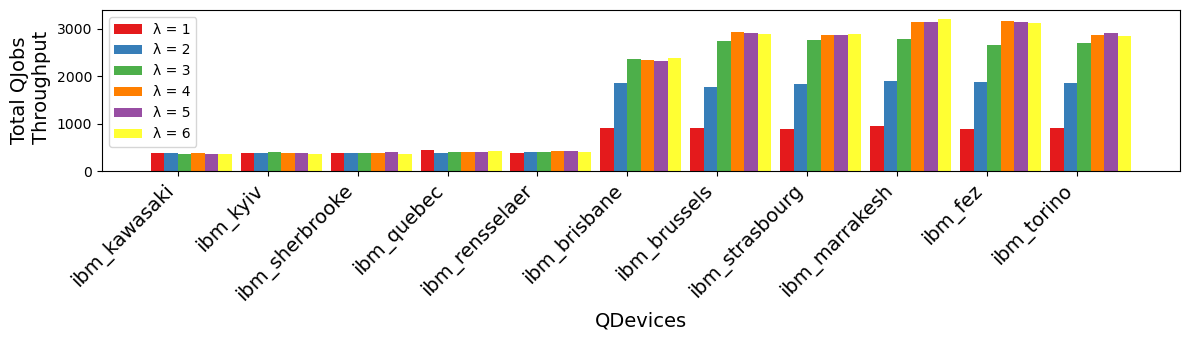

In [16]:
# List of datasets and corresponding labels
# value_counts_0_5 = [363, 367, 372, 408, 395, 473, 411, 456, 477, 495, 458]
value_counts_1 = tot_troughput[1]
value_counts_2 = tot_troughput[2]
value_counts_3 = tot_troughput[3]
value_counts_4 = tot_troughput[4]
value_counts_5 = tot_troughput[5]
value_counts_6 = tot_troughput[6]

datasets = [value_counts_1, value_counts_2, value_counts_3, value_counts_4, value_counts_5, value_counts_6]
labels = ['λ = 1', 'λ = 2', 'λ = 3', 'λ = 4', 'λ = 5', 'λ = 6']  # Labels for each dataset
colors = ["#E41A1C", "#377EB8", "#4DAF4A", "#FF7F00", "#984EA3", "#FFFF33"]   # suggested by chatGPT (color blind friendly)

# Number of devices (assuming this matches the length of your 'Devices' column)
num_devices = len(device_names)

# Create an array of positions for the x-axis (one for each device)
x = np.arange(num_devices)

# Define the width of the bars (adjust depending on the number of datasets)
width = 0.15  # Width of each bar

plt.figure(figsize=(12, 3.5))

# Plot each dataset
for i, dataset in enumerate(datasets):
    # Plot bars for each dataset
    plt.bar(x + i * width, dataset, width, label=labels[i], color=colors[i])

# Add labels and title
plt.xlabel('QDevices', fontsize=14)
plt.ylabel('Total QJobs\n Throughput', fontsize=14)
# plt.title('Total Jobs Processed for Different Lambda Values', fontsize=16)

# Set custom x-tick labels using the device names from averages_df
plt.xticks(ticks=x + width * 1.5, labels=device_names, rotation=45, ha='right', fontsize=14)
plt.ylim(0, 3400)

# Add legend to differentiate between datasets
plt.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("throughput-IBM.png")
# Display the plot
plt.show()

### Plotting Figure 6 (Bottom)

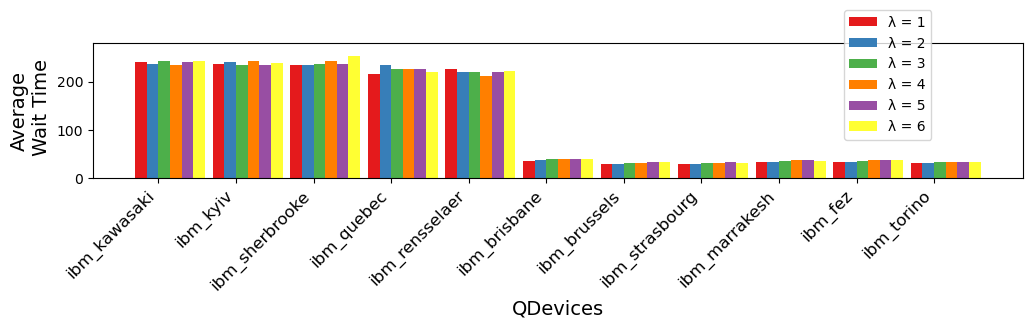

In [22]:
avg_wait_time_1 = avg_wait_time[1]
avg_wait_time_2 = avg_wait_time[2]
avg_wait_time_3 = avg_wait_time[3]
avg_wait_time_4 = avg_wait_time[4]
avg_wait_time_5 = avg_wait_time[5]
avg_wait_time_6 = avg_wait_time[6]

# Create a list of the dataframes for easier iteration

datasets = [avg_wait_time_1, avg_wait_time_2, avg_wait_time_3, avg_wait_time_4, avg_wait_time_5, avg_wait_time_6]
labels = ['λ = 1', 'λ = 2', 'λ = 3', 'λ = 4', 'λ = 5', 'λ = 6']  # Labels for the legend
# colors = ["#f5b7b1", "#d2b4de", "#85c1e9", "#a9dfbf", "#f7dc6f", "#ccd1d1"]   
colors = ["#E41A1C", "#377EB8", "#4DAF4A", "#FF7F00", "#984EA3", "#FFFF33"] # suggested by chatGPT (color blind friendly)

# Number of devices
num_devices = len(device_names)

# Create an array of positions for the x-axis (one for each device)
x = np.arange(num_devices)

# Define width of bars (adjust depending on number of datasets)
width = 0.15  # Width of each bar

plt.figure(figsize=(12, 1.75))

# Plot each dataset
for i, df in enumerate(datasets):
    plt.bar(x + i * width, df, width, label=labels[i], capsize=5, color=colors[i])

# Add labels and title
plt.xlabel('QDevices', fontsize=14)
plt.ylabel('Average\n Wait Time', fontsize=14)

# Set custom x-tick labels using the device names from the first dataset (assuming all datasets have the same devices)
plt.xticks(ticks=x + width * 1.5, labels=device_names, rotation=45, ha='right', fontsize=12)

plt.ylim(0, 280)

# Add legend to differentiate between datasets
plt.legend(loc='upper left', bbox_to_anchor=(0.8, 1.3))

plt.savefig("waittime-IBM.png")
plt.show()

### Plotting Figure 7

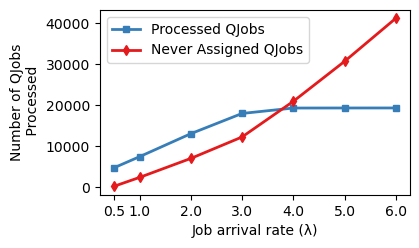

In [6]:
MARKERSIZE = 5
FONTSIZE = 10
# Data
lambdas = [0.5, 1, 2, 3, 4, 5, 6]
processed_jobs = list(processed.values())
not_processed_jobs = list(notprocessed.values())

color = ['#56B4E9', '#E69F00']
# Create the plot
plt.figure(figsize=(4, 2.4))

# Plot the lines for processed and not processed jobs
plt.plot(lambdas, processed_jobs, label='Processed QJobs', marker='s', color="#377EB8", linewidth=2, markersize=MARKERSIZE)
plt.plot(lambdas, not_processed_jobs, label='Never Assigned QJobs', marker='d', color="#E41A1C", linewidth=2, markersize=MARKERSIZE)

# Adding labels and title
plt.xlabel('Job arrival rate (λ)', fontsize=FONTSIZE)
plt.ylabel('Number of QJobs\n Processed', fontsize=FONTSIZE)
plt.xticks(lambdas, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Add legend
plt.legend(fontsize=FONTSIZE)
plt.show()

In [7]:
# All average fidelities and standard deviations
avg_fidelities = list(avg_fidelity_.values())
std_devs = list(std_fidelity_.values())

# Flatten the lists
all_fidelities = np.concatenate(avg_fidelities)
all_std_devs = np.concatenate(std_devs)

# Calculate variances
variances = all_std_devs**2

# Calculate weights (w = 1/variance)
weights = 1 / variances

# Calculate weighted average fidelity
weighted_avg_fidelity = np.sum(weights * all_fidelities) / np.sum(weights)

# Calculate overall standard deviation
overall_std_dev = np.sqrt(1 / np.sum(weights))

print(f"Weighted Average Fidelity: {weighted_avg_fidelity:.4f}")
print(f"Overall Standard Deviation: {overall_std_dev:.4f}")

Weighted Average Fidelity: 0.7513
Overall Standard Deviation: 0.0091
